In [1]:
import datetime
import json
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyliftover
import seaborn as sns

from annotating_nmd import * 

## 1. Dataframe creation and variant filtering

Convert chromosomes files into tables and combine everything into one dataframe.

In [2]:
DATA_PATH = "data_dir/canonical_ensemble"

In [3]:
chromosomes = ['chr' + str(i) for i in range(1, 23)]  # only autosomes
frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]

/tmp/ipykernel_91551/3667480233.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]
/tmp/ipykernel_91551/3667480233.py:2: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]
/tmp/ipykernel_91551/3667480233.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]
/tmp/ipykernel_91551/3667480233.py:2: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.

In [4]:
all_chrom_df = pd.concat(frames)

In [5]:
all_chrom_df.shape

(67528142, 14)

In [6]:
all_chrom_df.dtypes

Chr                     object
Position                 int64
rsID                    object
Ref                     object
Alt                     object
Impact                  object
Consequence             object
Gene_symbol             object
Canonical_transcript    object
cDNA_position           object
LoF                     object
LoF_flag                object
LoF_filter              object
AC                       int64
dtype: object

In [7]:
all_chrom_df = all_chrom_df.rename(columns={'Chr': 'CHROM', 'Position': 'POS', 'Ref': 'REF', 'Alt': 'ALT'})

In [8]:
all_chrom_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC
0,chr1,12541,.,C,G,"MODIFIER, MODIFIER, MODIFIER","intron_variant&non_coding_transcript_variant, ...","DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,1
1,chr1,12591,rs1553119381,C,T,"MODIFIER, MODIFIER, MODIFIER","intron_variant&non_coding_transcript_variant, ...","DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,5
2,chr1,12592,.,C,T,"MODIFIER, MODIFIER, MODIFIER","intron_variant&non_coding_transcript_variant, ...","DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,5
3,chr1,12599,rs1437963543,CT,C,"LOW, MODIFIER, MODIFIER",splice_polypyrimidine_tract_variant&intron_var...,"DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,14
4,chr1,12612,rs1205998786,GGT,G,"LOW, MODIFIER, MODIFIER",splice_region_variant&non_coding_transcript_ex...,"DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",98-99,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621633,chr22,50799702,rs4081531,G,A,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,377
1621634,chr22,50799821,rs149733995,A,C,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,11
1621635,chr22,50801218,rs368061391,G,A,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,1
1621636,chr22,50801236,rs113976139,C,G,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,18


### Data distribution analysis

#### Representation of the loss of function (LOF) variants

In [9]:
high_counts = all_chrom_df[all_chrom_df['Impact'].str.contains("HIGH", na=False)].shape[0]
high_counts_clean = len(all_chrom_df[(all_chrom_df['Impact'].str.contains("HIGH", na=False)) & 
                                         (all_chrom_df['LoF_flag'].isnull()) &
                                         (all_chrom_df['LoF_filter'].isnull())])

print("Total number of LOF variants on automosmas:", high_counts)
print("Total number of LOF variants without flags/filters on automosmas:", high_counts_clean)


Total number of LOF variants on automosmas: 1504202
Total number of LOF variants without flags/filters on automosmas: 1206986


In [11]:
total_variant_count = all_chrom_df.shape[0]
per_lof = round(high_counts * 100 / total_variant_count, 2)
per_lof_clean = round(high_counts_clean * 100 / total_variant_count, 1)

print(f"Autosomes contain {per_lof}% of LoF in total, of which {per_lof_clean}% do not contain LoF flags/filters.")


Autosomes contain 2.23% of LoF in total, of which 1.8% do not contain LoF flags/filters.


#### LOF flags and filters analysis

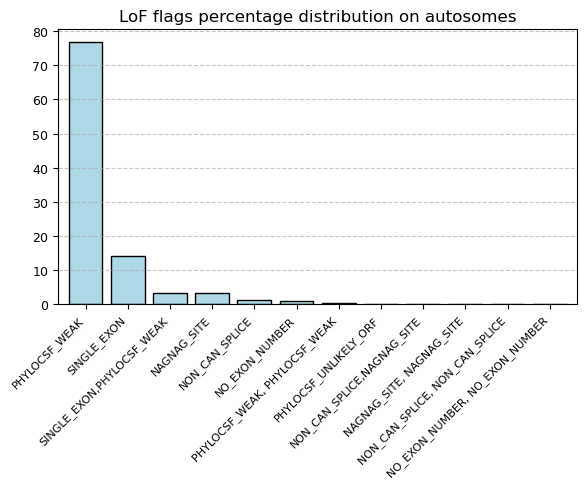

In [12]:
counts_LoF_flag = all_chrom_df['LoF_flag'].value_counts()
percentages_LoF_flag = counts_LoF_flag / counts_LoF_flag.sum() * 100

plt.figure(figsize=(6, 5))
percentages_LoF_flag.plot(kind='bar', color='lightblue', edgecolor='black', width=0.8)
plt.title('LoF flags percentage distribution on autosomes', fontsize=12)
#plt.xlabel('Flags', fontsize=12)
plt.xlabel('')
#plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('images/lof_flag_counts.png', bbox_inches='tight', dpi=300)
plt.show()

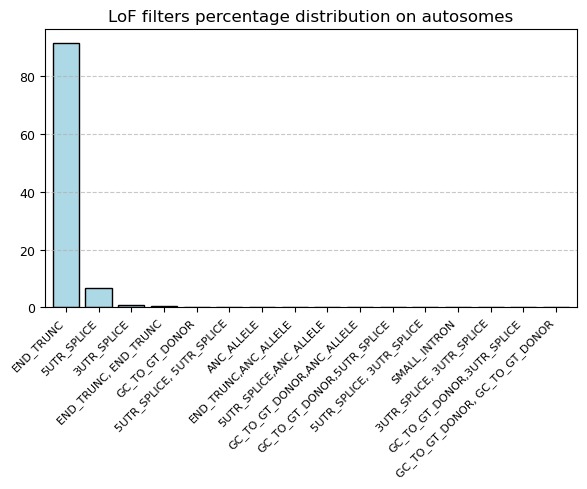

In [13]:
counts_LoF_filter = all_chrom_df['LoF_filter'].value_counts()
percentages_LoF_filter = counts_LoF_filter / counts_LoF_filter.sum() * 100

plt.figure(figsize=(6, 5))
percentages_LoF_filter.plot(kind='bar', color='lightblue', edgecolor='black', width=0.8)
plt.title('LoF filters percentage distribution on autosomes', fontsize=12)
#plt.xlabel('Filters', fontsize=12)
plt.xlabel('')
#plt.ylabel('Percentage', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('images/lof_filter_counts.png', bbox_inches='tight', dpi=300)
plt.show()

#### Variants distribution by impact

In [14]:
impact_categories = ['HIGH', 'MODERATE', 'LOW', 'MODIFIER']
impact = all_chrom_df[all_chrom_df['Impact'].isin(impact_categories)]

impact_counts = impact['Impact'].value_counts()
impact_counts

Impact
MODIFIER    32906073
MODERATE     9269599
LOW          5822550
HIGH         1091908
Name: count, dtype: int64

In theory, the ratio of variants with `high + moderate` impact to `low` impact should be approximately 2:1, but in real populations various shifts are possible, and in this case we observe a distribution of 1,8 to 1.

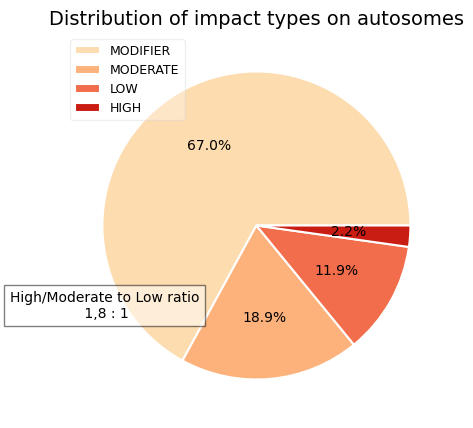

In [42]:
colors = list(sns.color_palette('OrRd', len(impact_counts)))

plt.figure(figsize=(5, 5))
labels = impact_counts.index
#explode = [0.12, 0, 0, 0]
plt.pie(impact_counts, 
                            autopct='%1.1f%%', 
                            textprops={'fontsize': 10}, 
                            #startangle=170,
                            colors=colors, 
                            wedgeprops=dict(edgecolor='white', 
                            linewidth=1.5),
                            #explode=explode
       )

plt.legend(labels, loc='upper left', fontsize=9, framealpha = 0.3)
plt.title('Distribution of impact types on autosomes', fontsize=14)
plt.text(-1.6, -0.6, 
         'High/Moderate to Low ratio\n                 1,8 : 1', 
         fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
plt.savefig('images/impact_counts_autosomes.png', bbox_inches='tight', dpi=300)
plt.show()


In [16]:
consequence_categories = ['stop_gained', 'frameshift_variant', 'splice_donor_variant', 'splice_acceptor_variant']
consequences = all_chrom_df[all_chrom_df['Consequence'].isin(consequence_categories)]

consequence_counts = consequences['Consequence'].value_counts()
consequence_counts

Consequence
frameshift_variant         492007
stop_gained                300052
splice_donor_variant       107811
splice_acceptor_variant     97111
Name: count, dtype: int64

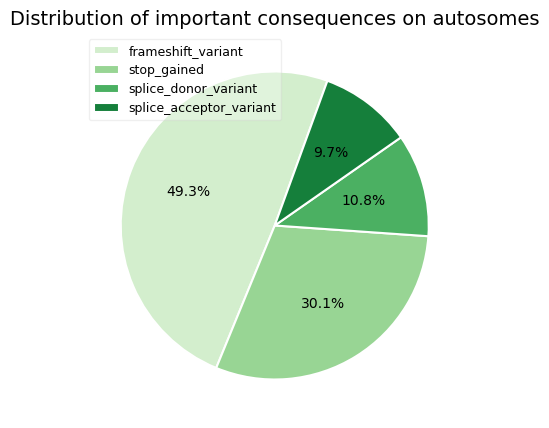

In [40]:
colors = list(sns.color_palette('Greens', len(consequence_counts)))

plt.figure(figsize=(5, 5))
labels = consequence_counts.index
#explode = [0.12, 0, 0, 0]
plt.pie(consequence_counts, 
                            autopct='%1.1f%%', 
                            textprops={'fontsize': 10}, 
                            startangle=70,
                            colors=colors, 
                            wedgeprops=dict(edgecolor='white', 
                            linewidth=1.5),
                            #explode=explode
       )

plt.legend(labels, loc='upper left', fontsize=9, framealpha = 0.3)
plt.title('Distribution of important consequences on autosomes', fontsize=14)
plt.savefig('images/consequence_counts_autosomes.png', bbox_inches='tight', dpi=300)
plt.show()


## Data filtering

In [18]:
all_chrom_df[all_chrom_df['Consequence'] == 'stop_gained']
all_chrom_df['REF'].nunique()

478291

Leave only single-nucleotide stopgains.

In [19]:
lof_final_df = all_chrom_df[all_chrom_df['Consequence'] == 'stop_gained']

In [47]:
lof_final_df = lof_final_df[~lof_final_df['cDNA_position'].str.contains('-')]

Remove variants that contain LOF flags and LOF filters.

In [48]:
lof_final_df = lof_final_df[lof_final_df['LoF_flag'].isnull()]
lof_final_df = lof_final_df[lof_final_df['LoF_filter'].isnull()]

In [49]:
lof_final_df.shape

(23051, 15)

In [50]:
lof_final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
174506,chr1,1825438,rs867938404,G,A,HIGH,stop_gained,GNB1,ENST00000378609,379,HC,NaN,NaN,1,0.145
191152,chr1,2024966,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,172,HC,NaN,NaN,1,0.245
191153,chr1,2024966,.,C,G,HIGH,stop_gained,GABRD,ENST00000378585,172,HC,NaN,NaN,1,0.245
191172,chr1,2024993,.,G,A,HIGH,stop_gained,GABRD,ENST00000378585,199,HC,NaN,NaN,1,0.245
191594,chr1,2025553,.,G,A,HIGH,stop_gained,GABRD,ENST00000378585,364,HC,NaN,NaN,1,0.245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614829,chr22,50721176,.,C,T,HIGH,stop_gained,SHANK3,ENST00000262795,3394,HC,NaN,NaN,1,0.123
1615180,chr22,50721521,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,3739,HC,NaN,NaN,5,0.123
1615531,chr22,50721995,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,4213,HC,NaN,NaN,2,0.123
1615796,chr22,50722415,.,A,T,HIGH,stop_gained,SHANK3,ENST00000262795,4633,HC,NaN,NaN,1,0.123


In [51]:
lof_final_df['REF'].unique()

array(['G', 'C', 'A', 'T'], dtype=object)

In [52]:
lof_final_df['ALT'].unique()

array(['A', 'G', 'T', 'C'], dtype=object)

### Add LOEUF score

The loss-of-function observed over expected upper bound fraction, or [LOEUF score](https://doi.org/10.1007/s00439-022-02509-x), is a metric that places each gene on a continuous scale of loss-of-function constraint. Low scores are highly correlated with disease genes and gene essentiality. 
  
Due to expected shifts in the LOEUF distribution between gnomAD v2.1.1 and v4.0, it recommemded to use a threshold of LOEUF < 0.6 for v4.0 and [LOEUF < 0.35 for v2](https://gnomad.broadinstitute.org/news/2024-03-gnomad-v4-0-gene-constraint/#loeuf-guidance). We use the threshold for gnomAD v.2 because data on LOEUF were taken specifically for this dataset.

Convert a file with metrics into a dataframe.

In [25]:
lof_metrics_by_gene = pd.read_table('../raw_data/plof_metrics/gnomad.v2.1.1.lof_metrics.by_gene.txt')
lof_metrics_by_gene

,gene,transcript,obs_mis,exp_mis,oe_mis,mu_mis,possible_mis,obs_mis_pphen,exp_mis_pphen,oe_mis_pphen,...,gene_type,gene_length,exac_pLI,exac_obs_lof,exac_exp_lof,exac_oe_lof,brain_expression,chromosome,start_position,end_position
0,MED13,ENST00000397786,871,1117.80,0.77921,0.000056,14195,314.0,529.750,0.59273,...,protein_coding,122678,1.000000e+00,0.0,64.3930,0.000000,NaN,17,60019966,60142643
1,NIPBL,ENST00000282516,846,1441.50,0.58688,0.000074,18540,158.0,543.100,0.29092,...,protein_coding,189655,1.000000e+00,1.0,110.5700,0.009044,NaN,5,36876861,37066515
2,SMC3,ENST00000361804,178,630.07,0.28251,0.000032,8109,21.0,182.520,0.11506,...,protein_coding,36946,1.000000e+00,0.0,58.5230,0.000000,NaN,10,112327449,112364394
3,CNOT1,ENST00000317147,561,1295.90,0.43290,0.000069,15670,51.0,290.680,0.17545,...,protein_coding,109936,1.000000e+00,3.0,90.1300,0.033285,NaN,16,58553855,58663790
4,RLF,ENST00000372771,669,972.87,0.68766,0.000047,12682,107.0,321.140,0.33319,...,protein_coding,79549,1.000000e+00,0.0,43.6070,0.000000,NaN,1,40627045,40706593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19699,OR7G2,ENST00000305456,177,181.12,0.97723,0.000009,2247,34.0,38.175,0.89064,...,protein_coding,1038,7.093800e-03,3.0,2.9635,1.012300,NaN,19,9212945,9213982
19700,OR7G3,ENST00000305444,164,163.92,1.00050,0.000008,2016,40.0,39.403,1.01520,...,protein_coding,939,4.059600e-01,1.0,4.8401,0.206610,NaN,19,9236688,9237626
19701,OR8D1,ENST00000357821,178,162.04,1.09850,0.000008,2002,65.0,54.179,1.19970,...,protein_coding,1026,2.159200e-01,1.0,2.7436,0.364480,NaN,11,124179708,124180733
19702,ZNF600,ENST00000338230,450,357.84,1.25750,0.000018,4794,138.0,124.070,1.11220,...,protein_coding,22597,1.477300e-13,16.0,9.6420,1.659400,NaN,19,53267448,53290044


Create a dictionary "transcript": "LOEUF value".

In [26]:
loeuf_by_transcript_dict = dict(zip(lof_metrics_by_gene['transcript'], lof_metrics_by_gene['oe_lof_upper']))

Write all matches to transcript keys in the LOEUF column.

In [27]:
lof_final_df.loc[:, 'LOEUF'] = lof_final_df['Canonical_transcript'].map(loeuf_by_transcript_dict)

Leave only highly conservative options (LOEUF < 0.35):

In [28]:
lof_final_df = lof_final_df[lof_final_df['LOEUF'] < 0.35]

In [29]:
lof_final_df.shape

(23074, 15)

### Add pext score

Information about pext boundaries is taken from [Singer-Berk M et al, 2023](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10029069/).

In [30]:
header_pext = ['chrom', 'pos', 'ref', 'alt', 'tx_annotation']

Convert a file containing the pext score values (only for stopgains) into a dataframe.

In [31]:
pext_raw_df = pd.read_table("data_dir/pext/stop_gained_rows.tsv", names=header_pext)

/tmp/ipykernel_91551/4201993334.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  pext_raw_df = pd.read_table("data_dir/pext/stop_gained_rows.tsv", names=header_pext)


In [32]:
tx_annotation_data = pext_raw_df['tx_annotation'].apply(lambda x: json.loads(x.replace("'", "\""))[0])
pext_tx_annotation = pd.DataFrame(tx_annotation_data.tolist())
pext_hg19_df = pd.concat([pext_raw_df.drop(columns=['tx_annotation']), pext_tx_annotation], axis=1)

In [33]:
pext_hg19_df = pext_hg19_df[(pext_hg19_df['chrom'] != 'X') & (pext_hg19_df['chrom'] != 'Y')]

Convert position values from hg19 to hg38.

In [34]:
pext_hg38_df = pext_hg19_df.copy()
pext_hg38_df['chrom'] = pext_hg38_df['chrom'].apply(lambda x: 'chr' + str(x))

In [54]:
lo = pyliftover.LiftOver('hg19', 'hg38')

for index, row in pext_hg38_df.iterrows():
    try:
        converted = lo.convert_coordinate(row['chrom'], row['pos'])
        if converted:
            pext_hg38_df.loc[index, 'chrom'] = converted[0][0]
            pext_hg38_df.loc[index, 'pos'] = converted[0][1]
    except Exception as e:
        print(f"Error converting coordinates for index {index}: {e}")

In [55]:
pext_dict = {(row['chrom'], row['pos'], row['ref'], row['alt']): row['mean_proportion'] for _, row in pext_hg38_df.iterrows()}

In [56]:
for index, row in lof_final_df.iterrows():
    key = (row['CHROM'], row['POS'], row['REF'], row['ALT'])
    
    if key in pext_dict:
        lof_final_df.loc[index, 'pext'] = pext_dict[key]
    else:
        lof_final_df.loc[index, 'pext'] = None

Keep only higher expressing variants (pext > 0.5):

In [57]:
lof_final_df['pext'] = lof_final_df['pext'].astype(float)
lof_final_df = lof_final_df[lof_final_df['pext'] > 0.5]

In [58]:
lof_final_df.shape

(15655, 16)

### Get NMD-escaping regions info

We use the code from [Torene et al., 2024](https://doi.org/10.1016/j.ajhg.2023.11.007). Full code is available [here](https://github.com/rebeccaito/nmd-escape/tree/main).

First obtain the required bed file for our data.

In [59]:
cds_bed_df = pd.read_table('data_dir/gencode_data/gencode.v45.annotation.bed', names=['chrom', 'start', 'end', 'cds_id', 'score', 'strand'])

cds_bed_df['cds_id'] = (cds_bed_df['cds_id'] + '_cds_0_0_' +
                              cds_bed_df['chrom'] + '_' +
                              (cds_bed_df['start'] + 1).astype(str) + '_' +
                              cds_bed_df['strand'].map({'+': 'f', '-': 'r'}))

In [60]:
cds_bed_df

,chrom,start,end,cds_id,score,strand
0,chr1,65564,65573,ENST00000641515.2_cds_0_0_chr1_65565_f,.,+
1,chr1,69036,70005,ENST00000641515.2_cds_0_0_chr1_69037_f,.,+
2,chr1,450742,451678,ENST00000426406.4_cds_0_0_chr1_450743_r,.,-
3,chr1,685718,686654,ENST00000332831.5_cds_0_0_chr1_685719_r,.,-
4,chr1,924431,924948,ENST00000616016.5_cds_0_0_chr1_924432_f,.,+
...,...,...,...,...,...,...
885744,chrM,10469,10763,ENST00000361335.1_cds_0_0_chrM_10470_f,.,+
885745,chrM,10759,12137,ENST00000361381.2_cds_0_0_chrM_10760_f,.,+
885746,chrM,12336,14145,ENST00000361567.2_cds_0_0_chrM_12337_f,.,+
885747,chrM,14148,14673,ENST00000361681.2_cds_0_0_chrM_14149_r,.,-


Determine NMD regions from a 6-column bed file of coding sequence regions.

In [61]:
nmd_bed_df = make_boundaries_df(cds_bed_df)

In [62]:
nmd_bed_df

index  chrom      start        end  \
transcript_name                                             
ENST00000000233.10 0  358020   chr7  127591212  127591296   
                   1  358019   chr7  127591033  127591088   
ENST00000000412.8  0  528168  chr12    8941820    8941940   
                   1  528167  chr12    8942415    8942470   
ENST00000000442.11 0  493539  chr11   64315706   64315963   
...                      ...    ...        ...        ...   
ENST00000713920.1  1  649116  chr16    1320462    1320517   
ENST00000713921.1  0  649156  chr16    1324729    1324790   
                   1  649155  chr16    1320462    1320517   
ENST00000713922.1  0  649327  chr16    1314756    1314858   
                   1  649326  chr16    1314321    1314376   

                                                           cds_id score  \
transcript_name                                                           
ENST00000000233.10 0  ENST00000000233.10_cds_0_0_chr7_127591213_f     .   
                   1  ENST00000000233.10_cds_0_0_chr7_127590963_f     .   
ENST00000000412.8  0    ENST00000000412.8_cds_0_0_chr12_8941821_r     .   
                   1    ENST00000000412.8_cds_0_0_chr12_8942416_r     .   
ENST00000000442.11 0  ENST00000000442.11_cds_0_0_chr11_64315707_f     .   
...                                                           ...   ...   
ENST00000713920.1  1    ENST00000713920.1_cds_0_0_chr16_1320438_f     .   
ENST00000713921.1  0    ENST00000713921.1_cds_0_0_chr16_1324730_f     .   
                   1    ENST00000713921.1_cds_0_0_chr16_1320438_f     .   
ENST00000713922.1  0    ENST00000713922.1_cds_0_0_chr16_1314757_f     .   
                   1    ENST00000713922.1_cds_0_0_chr16_1314293_f     .   

                     strand     transcript_name cds_size  
transcript_name                                           
ENST00000000233.10 0      +  ENST00000000233.10       84  
                   1      +  ENST00000000233.10       55  
ENST00000000412.8  0      -   ENST00000000412.8      120  
                   1      -   ENST00000000412.8       55  
ENST00000000442.11 0      +  ENST00000000442.11      257  
...                     ...                 ...      ...  
ENST00000713920.1  1      +   ENST00000713920.1       55  
ENST00000713921.1  0      +   ENST00000713921.1       61  
                   1      +   ENST00000713921.1       55  
ENST00000713922.1  0      +   ENST00000713922.1      102  
                   1      +   ENST00000713922.1       55  

[213979 rows x 9 columns]

### Add NMD info to dataframe

In [63]:
nmd_bed_df = nmd_bed_df.rename(columns={'transcript_name': 'transcript'})
nmd_bed_df = nmd_bed_df.reset_index()
nmd_bed_df = nmd_bed_df.drop('transcript_name', axis=1)
nmd_bed_df = nmd_bed_df.drop('level_1', axis=1)
nmd_bed_df = nmd_bed_df.drop('index', axis=1)

In [64]:
nmd_bed_df

,chrom,start,end,cds_id,score,strand,transcript,cds_size
0,chr7,127591212,127591296,ENST00000000233.10_cds_0_0_chr7_127591213_f,.,+,ENST00000000233.10,84
1,chr7,127591033,127591088,ENST00000000233.10_cds_0_0_chr7_127590963_f,.,+,ENST00000000233.10,55
2,chr12,8941820,8941940,ENST00000000412.8_cds_0_0_chr12_8941821_r,.,-,ENST00000000412.8,120
3,chr12,8942415,8942470,ENST00000000412.8_cds_0_0_chr12_8942416_r,.,-,ENST00000000412.8,55
4,chr11,64315706,64315963,ENST00000000442.11_cds_0_0_chr11_64315707_f,.,+,ENST00000000442.11,257
...,...,...,...,...,...,...,...,...
213974,chr16,1320462,1320517,ENST00000713920.1_cds_0_0_chr16_1320438_f,.,+,ENST00000713920.1,55
213975,chr16,1324729,1324790,ENST00000713921.1_cds_0_0_chr16_1324730_f,.,+,ENST00000713921.1,61
213976,chr16,1320462,1320517,ENST00000713921.1_cds_0_0_chr16_1320438_f,.,+,ENST00000713921.1,55
213977,chr16,1314756,1314858,ENST00000713922.1_cds_0_0_chr16_1314757_f,.,+,ENST00000713922.1,102


Search for a match by transcript. When found, check if the position falls within the boundaries.

In [65]:
%%time

mask_transcript = lof_final_df['Canonical_transcript'].isin(nmd_bed_df['transcript'].str.split('.').str[0])
lof_final_df.loc[~mask_transcript, 'NMD_escape'] = 'NO_TRANSCRIPT'

for index, row in nmd_bed_df.iterrows():
    transcript_split = row['transcript'].split('.')[0]
    
    mask_all = (lof_final_df['Canonical_transcript'] == transcript_split) & \
             (lof_final_df['POS'] >= row['start']) & \
             (lof_final_df['POS'] <= row['end'])
    
    lof_final_df.loc[mask_all, 'NMD_escape'] = 'YES'


lof_final_df.loc[(lof_final_df['NMD_escape'] != 'YES') & (lof_final_df['NMD_escape'] != 'NO_TRANSCRIPT'), 'NMD_escape'] = 'NO'

<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 4min 32s, sys: 703 ms, total: 4min 33s
Wall time: 4min 34s


In [66]:
lof_final_df['NMD_escape'].value_counts()

NMD_escape
NO               13280
YES               2373
NO_TRANSCRIPT        2
Name: count, dtype: int64

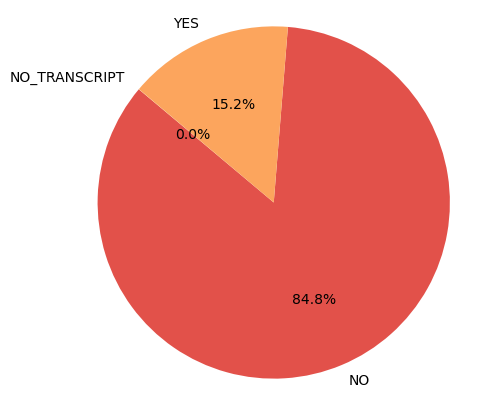

In [67]:
nmd_counts = lof_final_df['NMD_escape'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(nmd_counts, 
        labels=nmd_counts.index, 
        autopct='%1.1f%%', 
        startangle=140,
        colors=sns.color_palette("Spectral")) 
plt.axis('equal')
plt.savefig('images/nmd_counts_autosomes.png', bbox_inches='tight', dpi=300)
plt.show()


In [68]:
lof_final_df.to_csv('data/lof_final_df.csv', index=False)

### Divide into NMD(+) and NMD(-) dataframes

In [69]:
nmd_escape_df = lof_final_df[lof_final_df['NMD_escape'] == 'YES']
nmd_undergo_df = lof_final_df[lof_final_df['NMD_escape'] == 'NO']

In [70]:
nmd_escape_df.shape  # NMD(-)

(2373, 17)

In [71]:
nmd_undergo_df.shape  # NMD(+)

(13280, 17)

In [72]:
nmd_escape_df.to_csv('data/nmd_escape_df.csv', index=False)
nmd_undergo_df.to_csv('data/nmd_undergo_df.csv', index=False)

## 2. Clinvar data processing

Transcripts are not listed in ClinVar, so we annotate the downloaded Clinvar file (GRCh38, version 20240331) using VEP 111.

In [73]:
clinvar_df = pd.read_table('data_dir/clinvar/new_clinvar_20240331_anno.vcf.tsv')

In [74]:
clinvar_df

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,CLNREVSTAT,MC,Consequence,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,cDNA_position,CANONICAL
0,chr1,69134,2205837,A,G,Likely_benign,single_nucleotide_variant,OR4F5:79501,"criteria_provided,_single_submitter",SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,167,YES
1,chr1,69581,2252161,C,G,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,"criteria_provided,_single_submitter",SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,614,YES
2,chr1,69682,2396347,G,A,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,"criteria_provided,_single_submitter",SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,715,YES
3,chr1,69769,2288999,T,C,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,"criteria_provided,_single_submitter",SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,802,YES
4,chr1,69995,2351346,G,C,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,"criteria_provided,_single_submitter",SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,1028,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34840143,chrNT_187693.1,273806,2219599,G,A,Likely_benign,single_nucleotide_variant,LILRA3:11026,"criteria_provided,_single_submitter",SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34840144,chrNT_187693.1,273866,2237818,A,C,Uncertain_significance,single_nucleotide_variant,LILRA3:11026,"criteria_provided,_single_submitter",SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34840145,chrNT_187693.1,274366,2206666,G,C,Uncertain_significance,single_nucleotide_variant,LILRA3:11026,"criteria_provided,_single_submitter",SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34840146,chrNT_187693.1,275068,2241971,T,C,Uncertain_significance,single_nucleotide_variant,LILRA3:11026|LOC126057115:126057115,"criteria_provided,_single_submitter",SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
clinvar_df['CLNREVSTAT'].unique()

array(['criteria_provided,_single_submitter',
       'criteria_provided,_multiple_submitters,_no_conflicts',
       'criteria_provided,_conflicting_classifications',
       'no_assertion_criteria_provided', 'no_classification_provided',
       'no_classification_for_the_single_variant',
       'reviewed_by_expert_panel',
       'no_classifications_from_unflagged_records', 'practice_guideline'],
      dtype=object)

In [76]:
sign_values = ['criteria_provided,_multiple_submitters,_no_conflicts', 'criteria_provided,_single_submitter',
                  'criteria_provided,_conflicting_classifications', 'reviewed_by_expert_panel', 
                  'practice_guideline']

clinvar_df = clinvar_df[clinvar_df['CLNREVSTAT'].isin(sign_values)]

Add the LOEUF score info and select only conditionally highly conservative options.

In [77]:
clinvar_df.loc[:, 'LOEUF'] = clinvar_df['Feature'].map(loeuf_by_transcript_dict)

/tmp/ipykernel_91551/623573721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinvar_df.loc[:, 'LOEUF'] = clinvar_df['Feature'].map(loeuf_by_transcript_dict)


In [78]:
clinvar_df = clinvar_df.query('LOEUF < 0.35')

Add the pext score info and select only conditionally highly conservative options.

In [79]:
for index, row in clinvar_df.iterrows():
    key = (row['CHROM'], row['POS'], row['REF'], row['ALT'])
    
    if key in pext_dict:
        clinvar_df.loc[index, 'pext'] = pext_dict[key]
    else:
        clinvar_df.loc[index, 'pext'] = None

In [80]:
clinvar_df['pext'] = clinvar_df['pext'].astype(float)

In [81]:
clinvar_df = clinvar_df[clinvar_df['pext'] > 0.5]

In [82]:
clinvar_df['pext'].notna().sum()

9293

Leave only variants on the canonical transcript.

In [83]:
clinvar_df = clinvar_df[clinvar_df['CANONICAL'] == 'YES']

Leave only variants on the autosomes.

In [84]:
clinvar_df['CHROM'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'],
      dtype=object)

In [85]:
clinvar_df = clinvar_df[~clinvar_df['CHROM'].isin(['chrMT', 'chrX', 'chrY', 'chrNT_113889.1'])]

Remove lines that do not contain information about the transcript or cDNA position.

In [86]:
clinvar_df = clinvar_df.dropna(subset=['cDNA_position', 'Feature'])

Leave only single-nucleotide variants.

In [87]:
clinvar_df = clinvar_df[~clinvar_df['cDNA_position'].str.contains('-')]

Leave only stopgains (nonsense), marked as P/LP.

In [88]:
clinvar_final_pat = clinvar_df[
    clinvar_df['CLNSIG'].str.contains('pathogenic', case=False) &
    ~clinvar_df['CLNSIG'].str.contains('pathogenicity') &
    clinvar_df['MC'].str.contains('nonsense') &
    clinvar_df['Consequence'].str.contains('stop_gained')
]

In [89]:
clinvar_final_pat['CLNSIG'].unique()

array(['Pathogenic', 'Likely_pathogenic', 'Pathogenic/Likely_pathogenic'],
      dtype=object)

Add NMD(+) or NMD(-) status and split dataframes.

In [90]:
mask_transcript = clinvar_final_pat['Feature'].isin(nmd_bed_df['transcript'].str.split('.').str[0])
clinvar_final_pat.loc[~mask_transcript, 'NMD_escape'] = 'NO_TRANSCRIPT'

for index, row in nmd_bed_df.iterrows():
    transcript_split = row['transcript'].split('.')[0]
    
    mask_all = (clinvar_final_pat['Feature'] == transcript_split) & \
             (clinvar_final_pat['POS'] >= row['start']) & \
             (clinvar_final_pat['POS'] <= row['end'])
    
    clinvar_final_pat.loc[mask_all, 'NMD_escape'] = 'YES'


clinvar_final_pat.loc[(clinvar_final_pat['NMD_escape'] != 'YES') & (clinvar_final_pat['NMD_escape'] != 'NO_TRANSCRIPT'), 'NMD_escape'] = 'NO'

/tmp/ipykernel_91551/84413560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinvar_final_pat.loc[~mask_transcript, 'NMD_escape'] = 'NO_TRANSCRIPT'


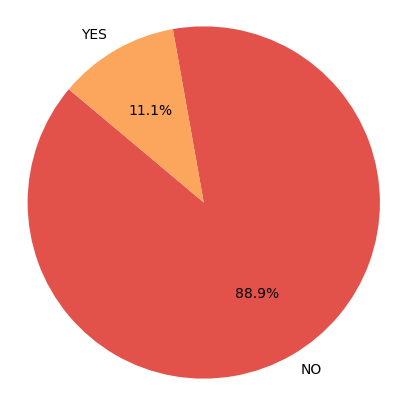

In [91]:
clinvar_nmd_counts = clinvar_final_pat['NMD_escape'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(clinvar_nmd_counts, 
        labels=clinvar_nmd_counts.index, 
        autopct='%1.1f%%', 
        startangle=140,
        colors=sns.color_palette("Spectral")) 
plt.axis('equal')
plt.savefig('images/nmd_counts_clinvar.png', bbox_inches='tight', dpi=300)
plt.show()


In [92]:
clinvar_nmd_escape_df = clinvar_final_pat[clinvar_final_pat['NMD_escape'] == 'YES']
clinvar_nmd_undergo_df = clinvar_final_pat[clinvar_final_pat['NMD_escape'] == 'NO']

In [93]:
clinvar_nmd_escape_df.to_csv('data/clinvar_nmd_escape_df.csv', index=False)
clinvar_nmd_undergo_df.to_csv('data/clinvar_nmd_undergo_df.csv', index=False)